# fig5_ivt
AR composites of integrated vapor transport (IVT)


## Imports

In [2]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap

In [3]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [4]:
# Set a default font for all matplotlib text (after setting, must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### ERA5 renalysis

In [7]:
## Set variable names (for saving data/figs)
var_names = 'IVT'
eofmode = 't' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance

# Select lat/lon grid
lonmin = 0
lonmax = 120
latmin = 0
latmax =  50

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat


### ERA5 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open IVT anomaly data
filepath_pattern = path_to_data + 'ERA5/IVT/daily/out.era5*.nc'
f1 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(f1.nbytes / 1e9))

# Create new dataset to rename lat lon
era = xr.Dataset({'ivte': (['time', 'lat', 'lon'], f1['p71.162'].values),
                  'ivtn': (['time', 'lat', 'lon'], f1['p72.162'].values)},
                  coords={'time': (['time'], f1.time.values),
                          'lat': (['lat'], f1.latitude.values),
                          'lon': (['lon'], f1.longitude.values)})

# Trim date range
start_date = '1979-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
era = era.sel(time=idx)

# Select DJF months
idx = (era.time.dt.month >= 12) | (era.time.dt.month <= 2)
era = era.sel(time=idx)

era


ds size in GB 2.85



<xarray.Dataset>
Dimensions:  (lat: 101, lon: 241, time: 3520)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-28T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.0 118.5 119.0 119.5 120.0
Data variables:
    ivte     (time, lat, lon) float32 236.6193 241.0619 ... -11.272614
    ivtn     (time, lat, lon) float32 -19.468597 -21.229797 ... -148.8051

### AR days

In [8]:
filepath = path_to_out + fname_id + 'hma_AR-types-djf.csv'
df = pd.read_csv(filepath)


In [9]:
# Combine AR Cat data w/ reanalysis data

# Add llj time series to the ERA dataset
era['ar'] = ('time', df.AR_CAT)
era = era.set_coords('ar')

# Select only LLJ days
idx = (era.ar >= 1)
era_ar = era.sel(time=idx)

# print results
print(era_ar)

<xarray.Dataset>
Dimensions:  (lat: 101, lon: 241, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.0 118.5 119.0 119.5 120.0
    ar       (time) int64 1 1 4 4 1 3 4 4 1 3 1 1 4 ... 1 1 1 1 1 1 1 2 2 2 1 1
Data variables:
    ivte     (time, lat, lon) float32 236.6193 241.0619 ... 88.385895 110.214935
    ivtn     (time, lat, lon) float32 -19.468597 -21.229797 ... -43.313354


### Compute AR composites

In [10]:
# Compute composites of each AR type
era_ar_comp = era_ar.groupby('ar').mean('time')
print(era_ar_comp)

<xarray.Dataset>
Dimensions:  (ar: 4, lat: 101, lon: 241)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.0 118.5 119.0 119.5 120.0
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * ar       (ar) int64 1 2 3 4
Data variables:
    ivte     (ar, lat, lon) float32 112.9889 111.77481 ... -55.481983 -29.058535
    ivtn     (ar, lat, lon) float32 42.110916 40.420837 ... -81.300575 -35.70787


## Figure 5

### Data for plotting

In [11]:
# lat/lon arrays
lats = era_ar_comp.lat.values
lons = era_ar_comp.lon.values

# IVT
uvec = era_ar_comp.ivte.values
vvec = era_ar_comp.ivtn.values
ivt = np.sqrt(uvec**2 + vvec**2)


### Common plot properties

In [12]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# Labels
plt_labels = ['AR Type 1', 'AR Type 2', 'AR Type 3','AR Type 4']


### Create figure

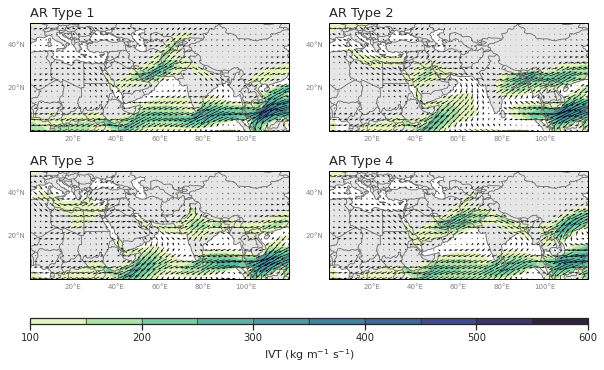

In [13]:
 # Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.0, cbar_size='2.5%',label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # IVT (filled contour)
    clevs_ivt = np.arange(100,601,50)
    cf = ax.contourf(lons, lats, ivt[k,:,:], transform=datacrs,
                    levels=clevs_ivt, cmap=cmo.deep)
    
    # IVT vectors
    ax.quiver(lons, lats, uvec[k,:,:], vvec[k,:,:], transform=datacrs,
        color='black', regrid_shape=20, pivot='middle')
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)
      
# Save figure
filepath = path_to_figs + 'ar_types_'+ fname_id + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
    